## Importing necessary libraries

In [ ]:
import tensorflow as tf
import numpy as np
import re, os
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

## Getting data from Kaggle

In [ ]:
import requests
import pandas as pd
import tarfile
import os

# Define the URL for the IMDb sentiment analysis dataset
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset_filename = "aclImdb_v1.tar.gz"

# Specify the download location
download_location = "./data/"

# Create the download directory if it doesn't exist
if not os.path.exists(download_location):
    os.makedirs(download_location)

# Download the dataset
response = requests.get(url)
with open(download_location + dataset_filename, 'wb') as f:
    f.write(response.content)

# Extract the downloaded file
with tarfile.open(download_location + dataset_filename, 'r:gz') as tar:
    tar.extractall(download_location)

# Define the path to the extracted dataset
dataset_path = download_location + "aclImdb/"

# Function to load the dataset into a Pandas DataFrame
def load_imdb_dataset(data_path):
    texts = []
    labels = []
    for category in ['train', 'test']:
        for sentiment in ['pos', 'neg']:
            folder_path = os.path.join(data_path, category, sentiment)
            for filename in os.listdir(folder_path):
                with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                    text = file.read()
                    texts.append(text)
                    labels.append(1 if sentiment == 'pos' else 0)
    return pd.DataFrame({'text': texts, 'label': labels})

# Load the dataset into a Pandas DataFrame
imdb_df = load_imdb_dataset(dataset_path)

# Display the first few rows of the DataFrame
print(imdb_df.head())


                                                text  label
0  One of the biggest hits of 1926, Brown of Harv...      1
1  The delivery of some very humorous rude lines ...      1
2  I saw a preview of Freebird at the Isle of Man...      1
3  I loved this movie. It was almost the same as ...      1
4  This movies chronicles the life and times of W...      1


In [ ]:
len(imdb_df)

50000

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into train, test, and validation sets
df_train, test_val_df = train_test_split(imdb_df, test_size=20000, random_state=42)
df_test, df_val = train_test_split(test_val_df, test_size=0.2, random_state=42)

# Display the shapes of the resulting DataFrames
print("Train set shape:", df_train.shape)
print("Test set shape:", df_test.shape)
print("Validation set shape:", df_val.shape)


Train set shape: (30000, 2)
Test set shape: (16000, 2)
Validation set shape: (4000, 2)


In [ ]:
df_val.head()

,text,label
26891,I would consider myself a fan of Dean Koontz; ...,1
25024,"For a film by a first time director, this is a...",1
11666,"The play Bell, Book, and Candle was a favorite...",1
40303,"First, let me start off by saying this film SO...",0
18010,The Perfectly Stupid Weapon. I think the guys ...,0


In [ ]:
df_test.head()

,text,label
24835,"From beginning to end, this is the most emotio...",0
28073,...that maybe someday people will wake up to. ...,1
31069,i would give this movie an 8.5 or a 9. I thoug...,1
25736,"A remarkable film, bringing to the surface all...",1
40229,Sigh. I'm baffled when I see a short like this...,0


In [ ]:
df_train['label'].value_counts()

0    15084
1    14916
Name: label, dtype: int64

## Preprocessing

In [ ]:
# Cleaning/Preprocessing Helper function

def preprocess(s):
  s = re.sub(r'@[a-zA-Z0-9_.]+ ', '', str(s))
  s = re.sub(r'#[a-zA-Z0-9_.]+ ', '', str(s))
  s = re.sub(r'''[^a-zA-Z0-9?. ]+''', '', s)
  s = re.sub(r''''[' ']+''', " ", s)
  s = re.sub(r'(\w)\1{2,}',r'\1',s)
  s = s.lower().strip()
  return s

In [ ]:
df_train['text'] = df_train['text'].apply(preprocess)
df_val['text'] = df_val['text'].apply(preprocess)
df_test['text'] = df_test['text'].apply(preprocess)

In [ ]:
def get_data(df):
  zeros, ones = df[df['label']==0], df[df['label']==1]
  zero_text, zero_labels = zeros['text'].to_numpy(), zeros['label'].to_numpy()
  one_text, one_labels = ones['text'].to_numpy(), ones['label'].to_numpy()
  X, Y = np.concatenate((one_text,zero_text)), np.concatenate((one_labels,zero_labels))
  return X,Y

In [ ]:
X_train,Y_train = get_data(df_train)
X_val,Y_val = get_data(df_val)
X_test,Y_test = get_data(df_test)

In [ ]:
X_train.shape,X_val.shape,X_test.shape

((30000,), (4000,), (16000,))

## Creating the Model

In [ ]:
# Instantiating the Tokenizer and creating sequences
tokenizer = tf.keras.preprocessing.text.Tokenizer(3000,oov_token=1)
tokenizer.fit_on_texts(X_train)
train_seq = tokenizer.texts_to_sequences(X_train)
val_seq = tokenizer.texts_to_sequences(X_val)
test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Padding all sequences
train_seq = tf.keras.preprocessing.sequence.pad_sequences(train_seq,maxlen=50,padding='post')
val_seq = tf.keras.preprocessing.sequence.pad_sequences(val_seq,maxlen=50,padding='post')
test_seq = tf.keras.preprocessing.sequence.pad_sequences(test_seq,maxlen=50,padding='post')

## Creating the Model

In [ ]:
# from tensorflow.keras.layers import Embedding,Dense,LSTM,Flatten,Dropout
# def create_model():
#   model = tf.keras.models.Sequential()
#   model.add(Embedding(3000,64))
#   model.add(LSTM(32))
#   model.add(Flatten())
#   model.add(Dense(64,activation='relu'))
#   model.add(Dropout(0.3))
#   model.add(Dense(32,activation='relu'))
#   model.add(Dropout(0.3))
#   model.add(Dense(4,activation='relu'))
#   model.add(Dense(1,activation='sigmoid'))
#   model.summary()
#   model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
#   return model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Conv1D, MaxPooling1D, Bidirectional, GlobalMaxPooling1D, Dense, Dropout

def create_model():
    model = tf.keras.models.Sequential()
    model.add(Embedding(input_dim=3000, output_dim=128))

    # Convolutional layers
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=64, return_sequences=True)))

    # Global Max Pooling layer
    model.add(GlobalMaxPooling1D())

    # Dense layers
    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(units=1, activation='sigmoid'))

    model.summary()

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model


## Full Model Training

In [ ]:
# HELPER FUNCTION

def plot(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['train_loss','val_loss'])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.legend(['train_accuracy','val_accuracy'])
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

In [ ]:
def train_full_model(train_seq,Y_train,val_seq,Y_val,test_seq,Y_test):
  model = create_model()
  history = model.fit(train_seq,Y_train,256,15,validation_data=(val_seq,Y_val),callbacks=[tf.keras.callbacks.ModelCheckpoint('FullModelCheckpoint.h5',save_best_only=True,verbose=1),tf.keras.callbacks.EarlyStopping(patience=6,verbose=1)])
  plot(history)
  model = tf.keras.models.load_model('FullModelCheckpoint.h5')
  print(model.evaluate(test_seq,Y_test))
  return model

## Active Learning

In [ ]:
# HELPER FUNCTIONS

def append_history(losses,val_losses,acc,val_acc,history):
  losses = losses + history.history['loss']
  val_losses = val_losses + history.history['val_loss']
  acc = acc + history.history['accuracy']
  val_acc = val_acc + history.history['val_accuracy']
  return losses,val_losses,acc,val_acc

def plot_merged_metrics(losses,val_losses,accuracies,val_accuracies):
  plt.plot(losses)
  plt.plot(val_losses)
  plt.legend(['train_loss','val_loss'])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

  plt.plot(accuracies)
  plt.plot(val_accuracies)
  plt.legend(['train_accuracy','val_accuracy'])
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
import collections

# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

def uncertainty_sampling(model, pool_features, pool_labels, sampling_size=2000):
    predictions = model.predict(pool_features)
    entropy = -np.sum(predictions * np.log(predictions + 1e-10), axis=1)  # Calculate prediction entropy
    sample_indices = np.argsort(entropy)[:sampling_size]  # Select samples with high uncertainty

    # Convert sample_indices to an array of integers
    sample_indices = np.array(sample_indices, dtype=np.int32)

    # Use boolean indexing to get the selected labels
    selected_labels = pool_labels[sample_indices]
    selected_samples = pool_features[sample_indices]

    return selected_samples, selected_labels



def train_small_models(train_features, train_labels, pool_features, pool_labels, val_seq, Y_val, test_seq, Y_test, iters=3, sampling_size=2000):

    losses, val_losses, accuracies, val_accuracies = [], [], [], []

    for iter_n in range(iters):
        # Create a new model for each iteration
        model = create_model()
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        checkpoint = tf.keras.callbacks.ModelCheckpoint(f'Checkpoint_{iter_n}.h5', save_best_only=True, verbose=1)

        print(f"Starting to train with {train_features.shape[0]} labeled samples")

        history = model.fit(train_features, train_labels, batch_size=256, epochs=15,
                            validation_data=(val_seq, Y_val),
                            callbacks=[checkpoint],
                            shuffle=True)  # Ensure training data shuffling for randomness

        losses, val_losses, accuracies, val_accuracies = append_history(losses, val_losses, accuracies, val_accuracies, history)

        # Evaluate and print accuracy on test data
        test_accuracy = model.evaluate(test_seq, Y_test)[1]
        print(f"Accuracy on test data after iteration {iter_n}: {test_accuracy}, Number of labeled samples: {train_features.shape[0]}")

        # Use uncertainty sampling to select samples from the pool
        selected_samples, selected_labels = uncertainty_sampling(model, pool_features, pool_labels, sampling_size)

        # Remove the chosen samples from the pool
        pool_features = np.delete(pool_features, selected_samples, axis=0)
        pool_labels = np.delete(pool_labels, selected_samples)

        # Add the sampled entries to the original data
        train_features = np.vstack((train_features, selected_samples))
        train_labels = np.hstack((train_labels, selected_labels))

    plot_merged_metrics(losses, val_losses, accuracies, val_accuracies)

    return model


## Ensembling

In [ ]:
# # Splitting Data into Oracle Set(Unlabelled set) and Original Training set
import sklearn.model_selection
train_features,pool_features,train_labels,pool_labels = sklearn.model_selection.train_test_split(train_seq,Y_train,test_size=29000,stratify=Y_train)
train_features.shape,pool_features.shape

((1000, 50), (29000, 50))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         384000    
                                                                 
 conv1d (Conv1D)             (None, None, 128)         49280     
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 128)         0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, None, 128)         98816     
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.5000
Epoch 2: val_loss improved from 0.69288 to 0.69287, saving model to Checkpoint_0.h5
4/4 [==============================] - 2s 667ms/step - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6929 - val_accuracy: 0.5132
Epoch 3/15
4/4 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.4920
Epoch 3: val_loss did not improve from 0.69287
4/4 [==============================] - 4s 1s/step - loss: 0.6925 - accuracy: 0.4920 - val_loss: 0.6930 - val_accuracy: 0.5132
Epoch 4/15
4/4 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4980
Epoch 4: val_loss did not improve from 0.69287
4/4 [==============================] - 3s 787ms/step - loss: 0.6932 - accuracy: 0.4980 - val_loss: 0.6930 - val_accuracy: 0.5132
Epoch 5/15
4/4 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.4960
Epoch 5: val_loss did not improve from 0.69287
4/4 [=============================

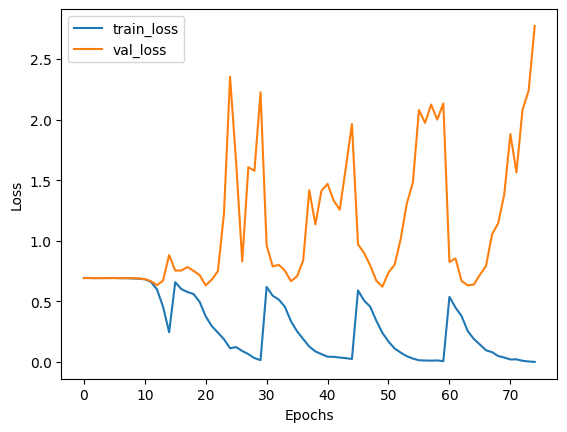

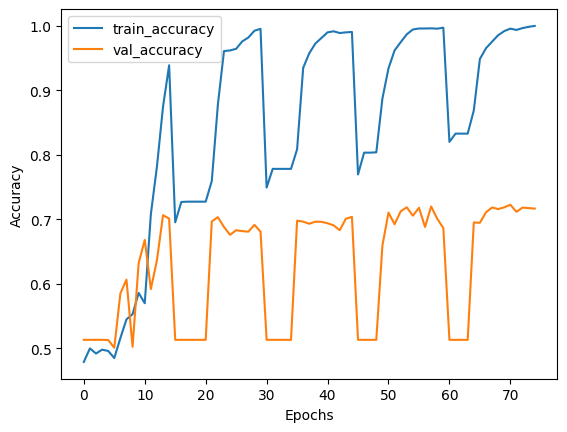

In [ ]:
# Training 3 Active Learning Models for Ensembling
al_model1 = train_small_models(train_features,train_labels,pool_features,pool_labels,val_seq,Y_val,test_seq,Y_test,iters=5, sampling_size=1000)
# al_model2 = train_small_models(train_features,train_labels,pool_features,pool_labels,val_seq,Y_val,test_seq,Y_test)
# al_model3 = train_small_models(train_features,train_labels,pool_features,pool_labels,val_seq,Y_val,test_seq,Y_test)